In [2]:
from datasets import load_dataset
import numpy as np
from matplotlib import pyplot as plt 

num_images = 100 # Number of images from each label
dataset = load_dataset("mnist") # Loading the dataset

In [3]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


In [4]:
training_data = dataset['train'] # This contains the training data
testing_data = dataset['test'] # This contains the testing data

# Training data is seperated according to their labels
labelled_training_data = [[] for i in range(10)]
for single_data in training_data:
    image = single_data['image']
    label = single_data['label']
    labelled_training_data[label].append(np.array(image).flatten())

labelled_training_data = np.array([labelled_training_data[i][:num_images] for i in range(10)]) # Taking specific number of images from each label
labelled_training_data = labelled_training_data.reshape(-1, labelled_training_data.shape[-1]).T
feature_mean = np.mean(labelled_training_data, axis=1, keepdims=True) # mean of all features
centered_training_data = labelled_training_data - feature_mean # centering the data
covariance_matrix = (1/10*num_images)*(np.matmul(centered_training_data, centered_training_data.T, dtype='float64')) # Covariance Matrix X.X^T
epsilon = 1e-6
covariance_matrix += epsilon*np.eye(covariance_matrix.shape[0]) # Adding small epsilon along the diagonal elements to avoid floating point errors

eigen_values, eigen_vectors = np.linalg.eigh(covariance_matrix) # Computing eigen_values and eigen vectors
descending_indices = np.argsort(eigen_values[::-1])
eigen_values = eigen_values[descending_indices] # eigen_values in descending order
eigen_vectors = eigen_vectors[:, descending_indices] # correspoding eigen_vectors

eigen_sum = np.sum(eigen_values) # sum of all eigen_values or the total variance
percentage_variance_explained = (eigen_values/eigen_sum)*100 # variance explained by particular PC is same as the percentage eigen_value contribution to the total eigen_sum.
cummulative_percentage = np.zeros(784)
cummulative_percentage[0] = percentage_variance_explained[0]
max_explained = 0 # Index till where most of the data is explained
for i in range(1, 784):
    cummulative_percentage[i] = cummulative_percentage[i-1] + percentage_variance_explained[i]
    if cummulative_percentage[i] > 95 and max_explained == 0:
        max_explained = i

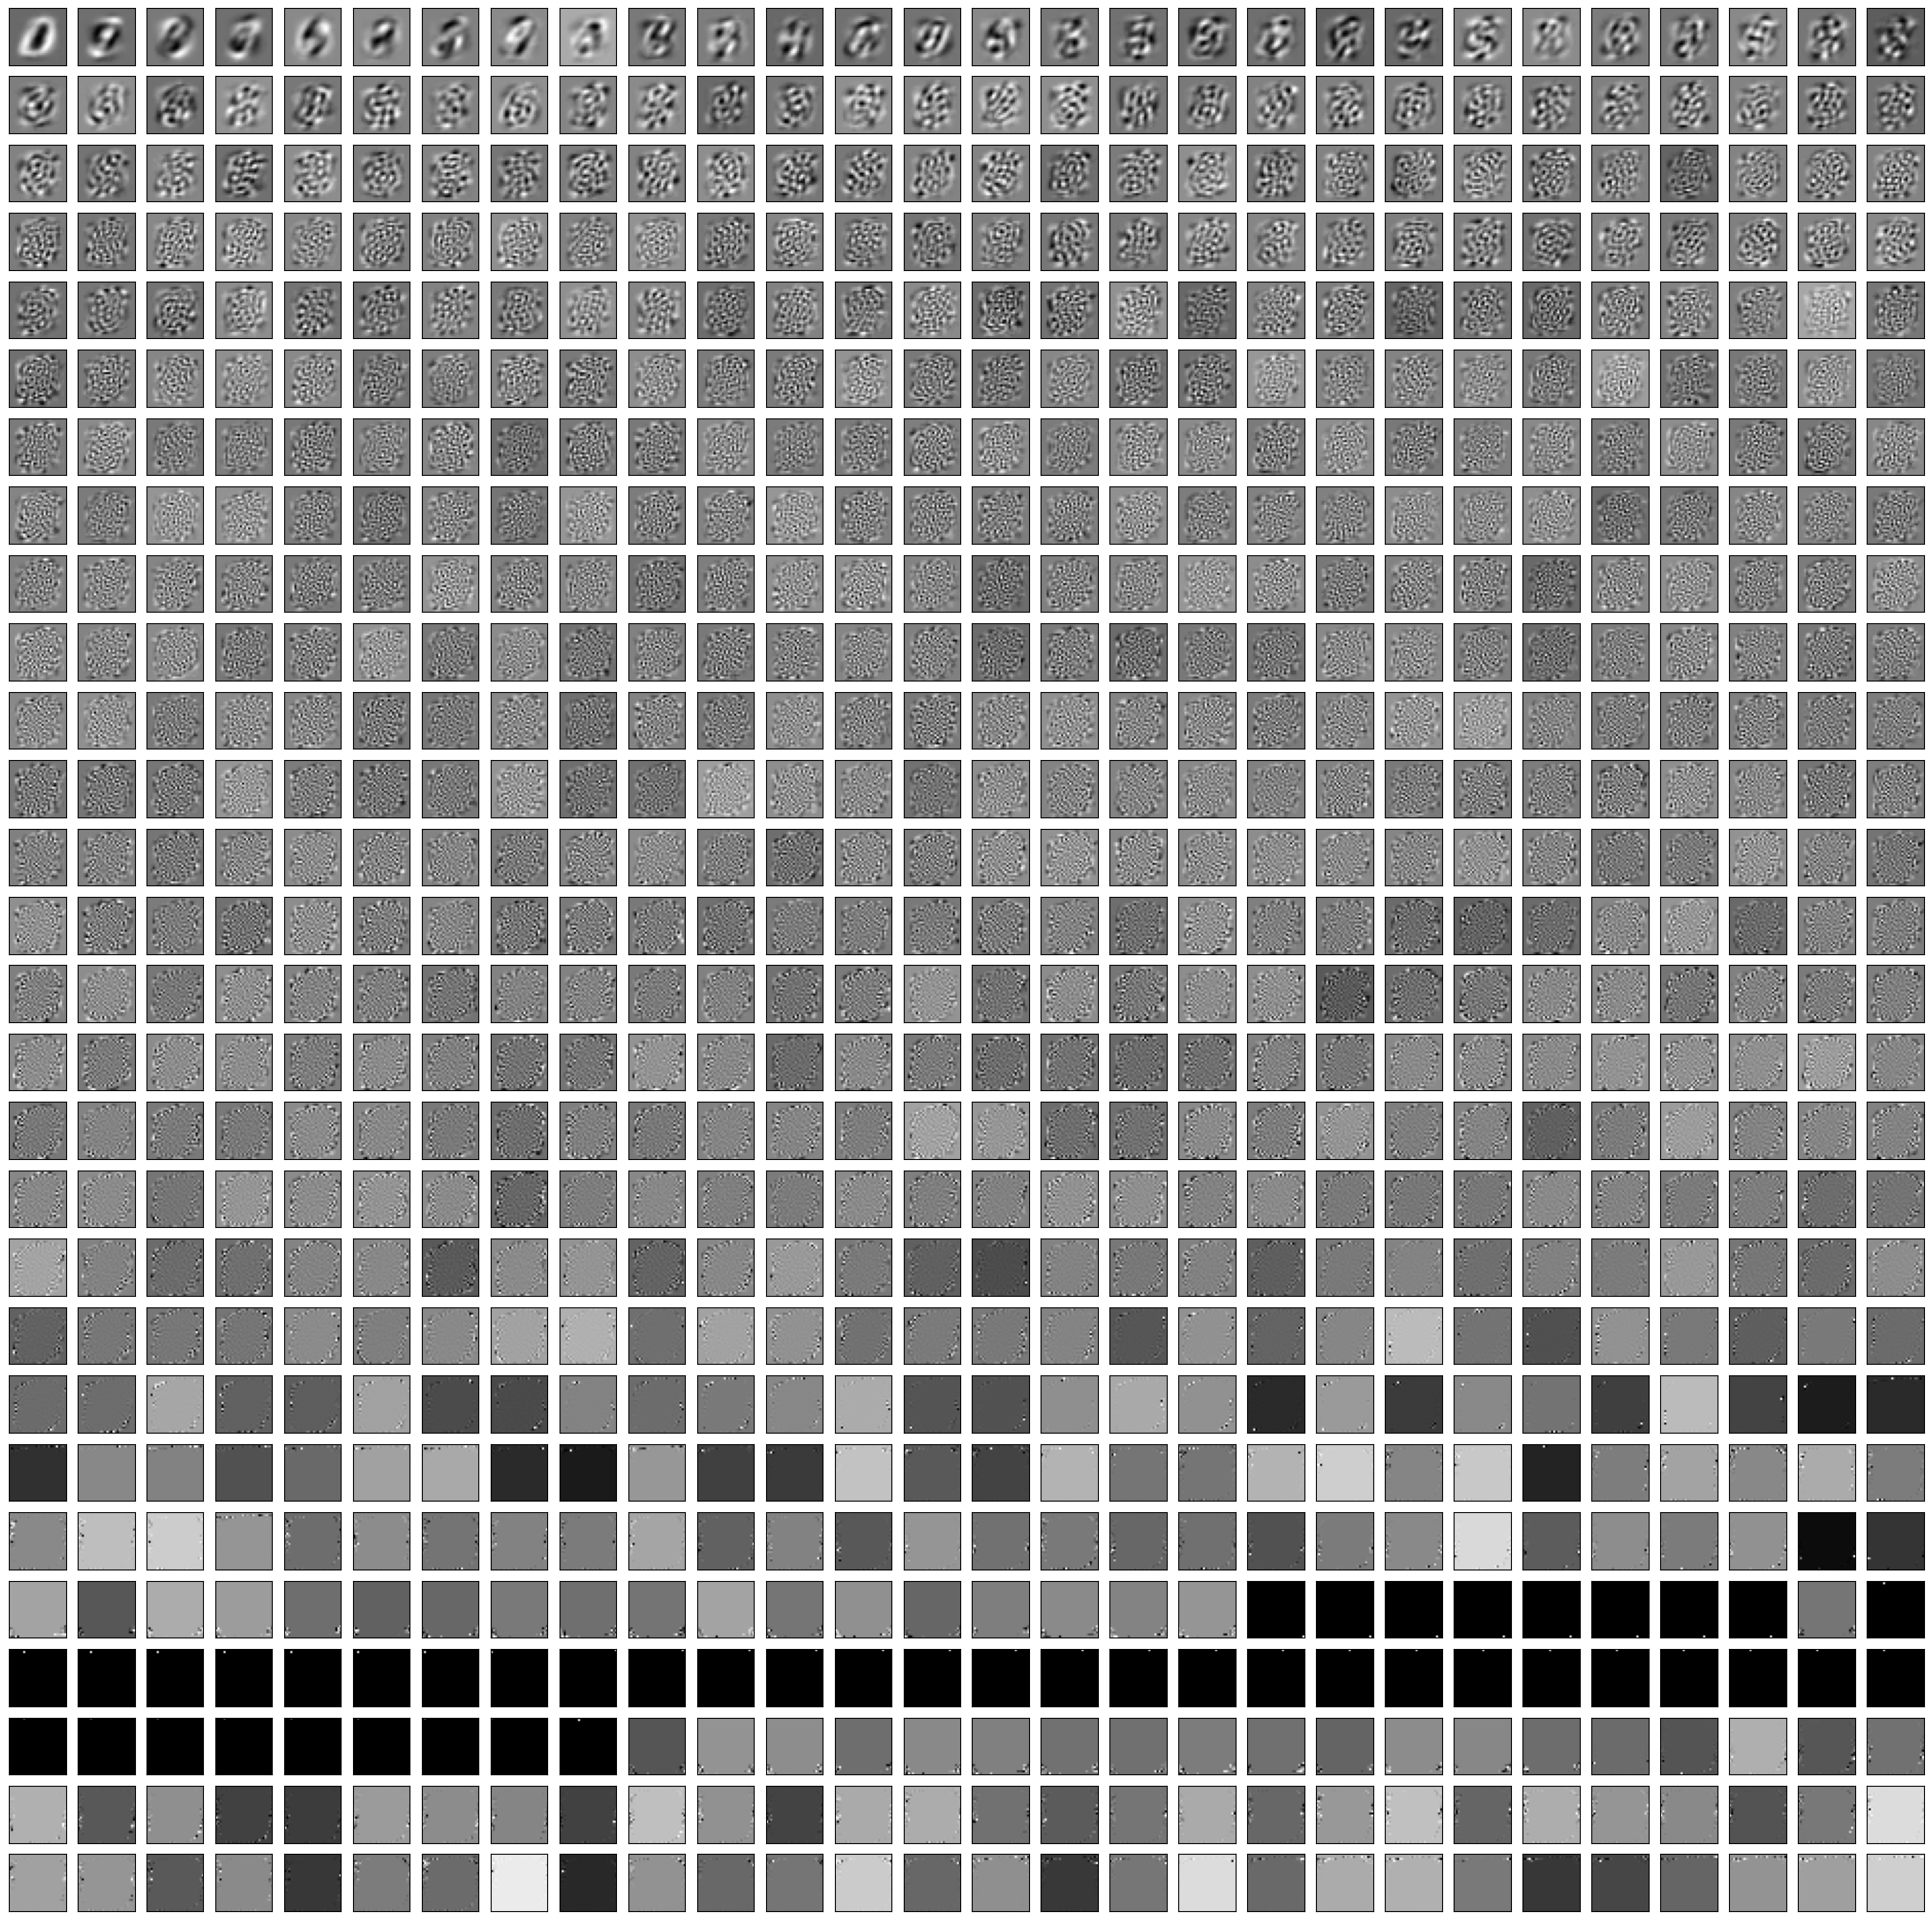

In [5]:
fig, axes = plt.subplots(28, 28, figsize=(28, 28))
principal_components = eigen_vectors.T
for i, pc in enumerate(principal_components):
    q, r = i//28, i%28
    axes[q][r].imshow(pc.reshape((28, 28)), cmap='gray')
    axes[q][r].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.savefig("images/Q1/pca")
plt.show()

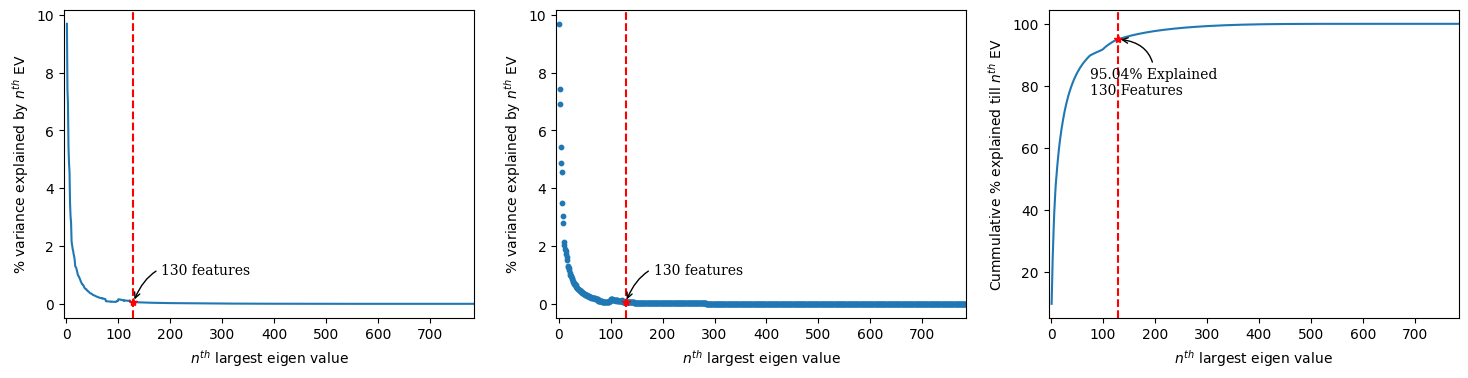

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].plot(np.linspace(1, 784, 784), percentage_variance_explained)
axes[1].scatter(np.linspace(1, 784, 784), percentage_variance_explained, s=10)
axes[2].plot(np.linspace(1, 784, 784), cummulative_percentage)
axes[0].plot(max_explained, percentage_variance_explained[max_explained], 'r*')
axes[1].plot(max_explained, percentage_variance_explained[max_explained], 'r*')
axes[2].plot(max_explained, cummulative_percentage[max_explained], 'r*')
axes[0].annotate(str(max_explained + 1) + " features", fontsize=10, family="serif",
        xy=(max_explained, percentage_variance_explained[max_explained]), xycoords="data", 
        xytext=(+20, +20), textcoords="offset points",
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.5"))
axes[1].annotate(str(max_explained + 1) + " features", fontsize=10, family="serif",
        xy=(max_explained, percentage_variance_explained[max_explained]), xycoords="data", 
        xytext=(+20, +20), textcoords="offset points",
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.5"))
axes[2].annotate(str(round(cummulative_percentage[max_explained], 2)) + "% Explained\n"  + str(max_explained + 1) + " Features", fontsize=10, family="serif",
        xy=(max_explained, cummulative_percentage[max_explained]), xycoords="data", 
        xytext=(-20, -40), textcoords="offset points",
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.5"))

for i in range(3):
    axes[i].set_xlim(-5, 785)
    axes[i].set_xlabel(r"$n^{th}$ largest eigen value")
    axes[i].axvline(x=max_explained, linestyle='--', label="Important eigen values", color='red')

axes[0].set_ylabel(r"% variance explained by $n^{th}$ EV")
axes[1].set_ylabel(r"% variance explained by $n^{th}$ EV")
axes[2].set_ylabel(r"Cummulative % explained till $n^{th}$ EV")

plt.show()

In [7]:
stored_data = np.matmul(centered_training_data.T, eigen_vectors) # this stores the values of x^T.w for all images along all principal directions
projections = []
for i in range(10*num_images):
    projections.append(np.array([stored_data[i, j]*eigen_vectors[:, j] for j in range(784)]))

projections = np.array(projections) # This stores the projections of all the images along the principal directions

[ 30  80 130]


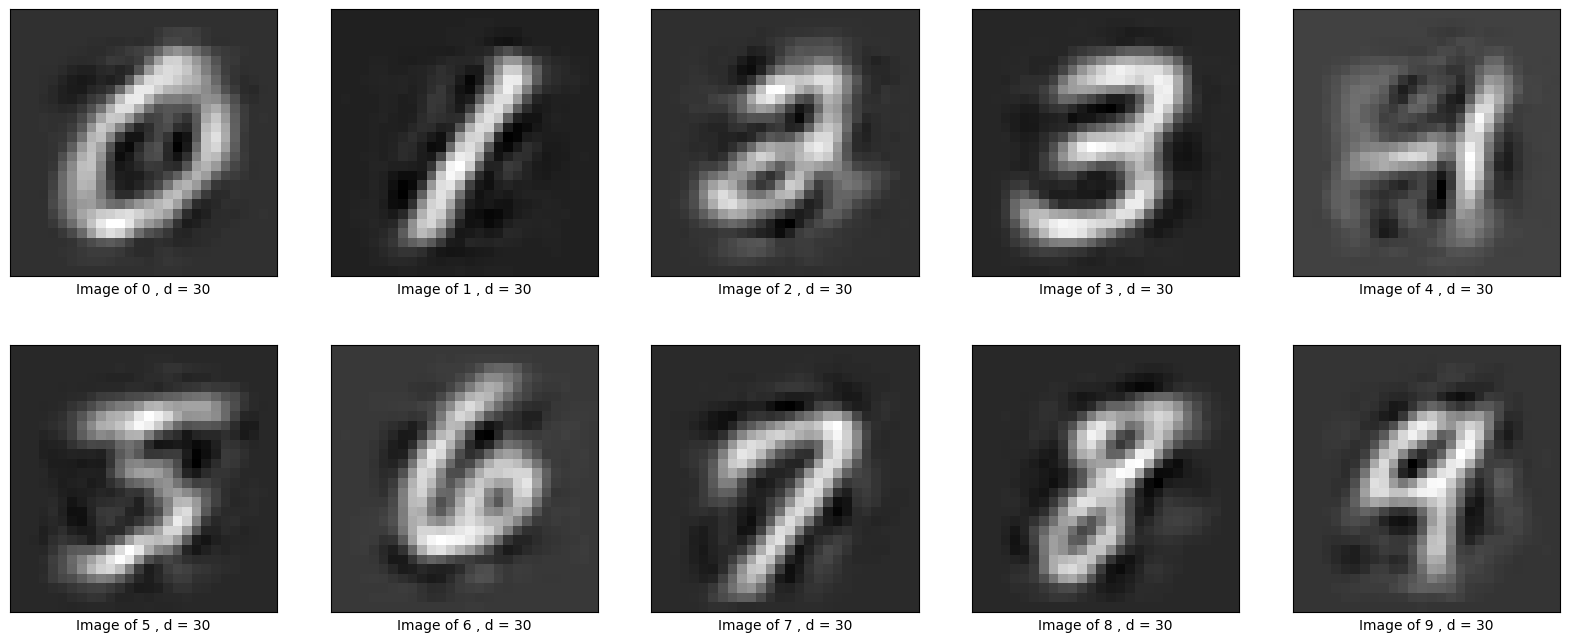

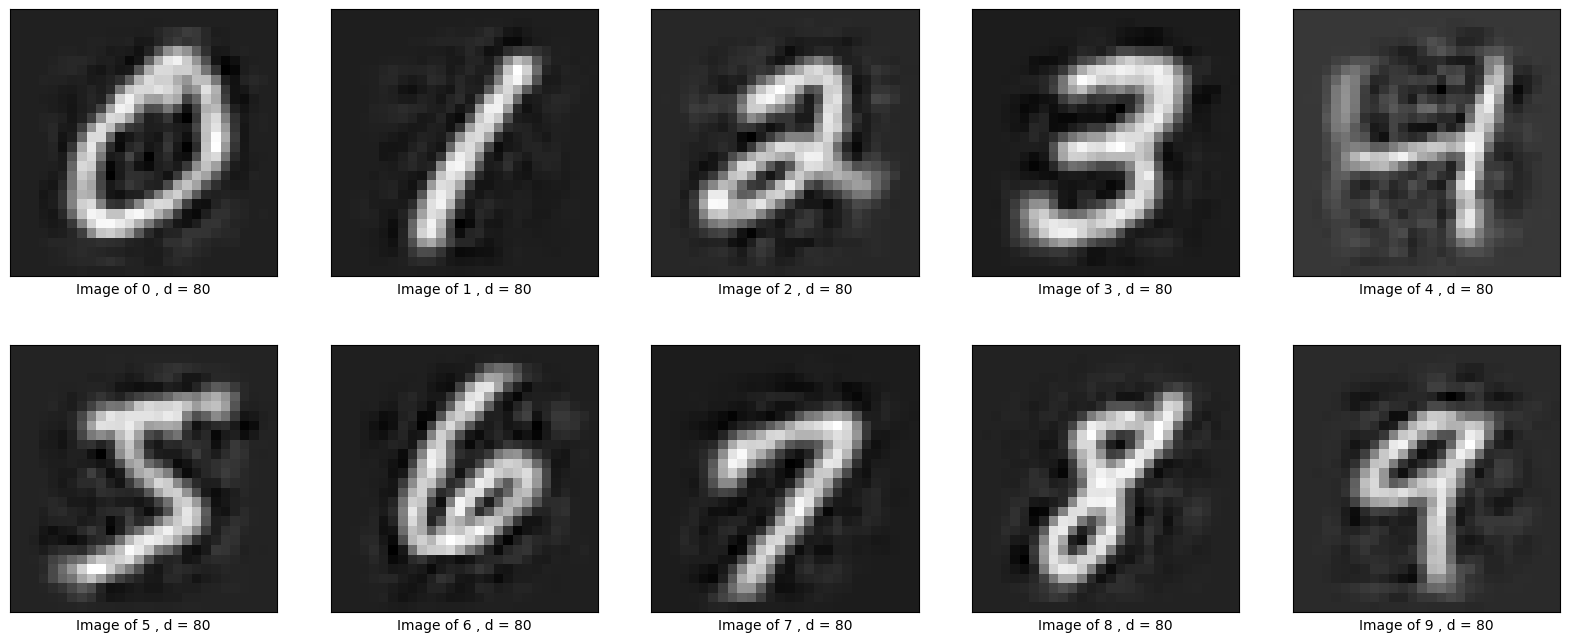

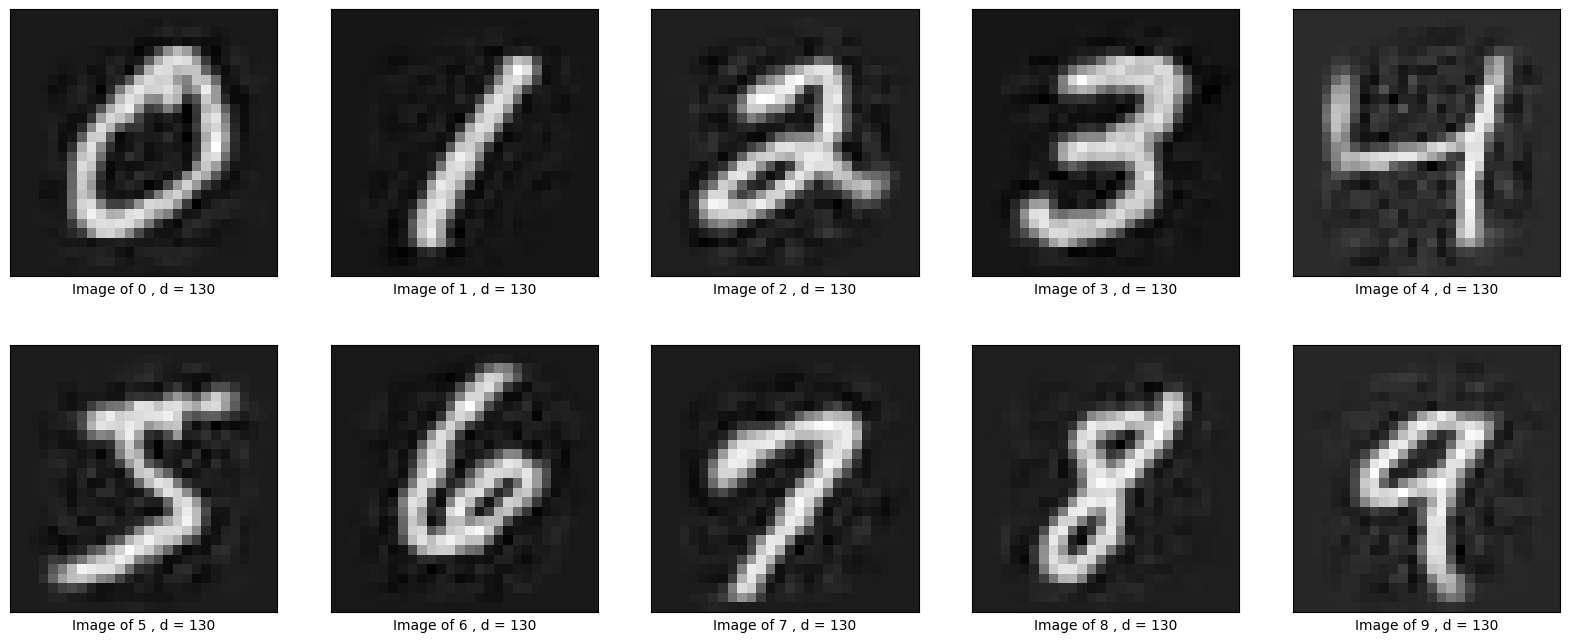

In [8]:
d = np.array([30, 80, 130])
print(d)
for d1 in d:
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for i in range(10):
        q, r = int(i/5), i%5
        temp = np.zeros((28, 28))
        for j in range(d1):
            temp += projections[100*i, j].reshape((28, 28))

        temp += feature_mean.reshape((28, 28))
        axes[q][r].imshow(temp, cmap='gray')
        axes[q][r].tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
        axes[q][r].set_xlabel("Image of " + str(i) + " , d = " + str(d1))
    plt.show()